In [1]:
!pip install yfinance

In [3]:
import pandas as pd
import yfinance as yf
from datetime import timedelta
import time
import os
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Study parameters
START_DATE = "2005-01-02"
END_DATE = "2025-01-02"

# Files
TICKERS_FILE = 'sp500_ticker_start_end.csv'
OUTPUT_FILE = 'price_spikes_with_future_close_final_version.csv'

# Load tickers and the dates when the company was in the S&P500 index
tickers_df = pd.read_csv(TICKERS_FILE, na_values=['', ' '])
tickers_df['start_date'] = pd.to_datetime(tickers_df['start_date'], errors='coerce')
tickers_df['end_date'] = pd.to_datetime(tickers_df['end_date'], errors='coerce')

# Fill missing dates
tickers_df['end_date'].fillna(pd.to_datetime(END_DATE), inplace=True)
tickers_df['start_date'].fillna(pd.to_datetime(START_DATE), inplace=True)

# Filter only companies active in the specified period
tickers_df = tickers_df[
    (tickers_df['end_date'] >= pd.to_datetime(START_DATE)) &
    (tickers_df['start_date'] <= pd.to_datetime(END_DATE))
].reset_index(drop=True)

# Remove output file if it exists
if os.path.exists(OUTPUT_FILE):
    os.remove(OUTPUT_FILE)

# Function returning the closest closing price after a given date
def get_future_close(df, current_date, years):
    future_date = current_date + pd.DateOffset(years=years)
    future_row = df[df['Date'] >= future_date]
    return future_row['Close'].iloc[0] if not future_row.empty else None

C:\Users\lukas\AppData\Local\Temp\ipykernel_17192\2497201529.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tickers_df['end_date'].fillna(pd.to_datetime(END_DATE), inplace=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_17192\2497201529.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [ ]:
# Main loop over tickers
for idx, row in tickers_df.iterrows():
    ticker = row['ticker']
    ticker_start = max(row['start_date'], pd.to_datetime(START_DATE))
    ticker_end = min(row['end_date'], pd.to_datetime(END_DATE))
    print(f"Downloading data: {ticker} from {ticker_start.date()} to {ticker_end.date()}")

    df = pd.DataFrame()
    for attempt in range(3):
        try:
            df = yf.download(ticker, start=ticker_start, end=ticker_end + timedelta(days=1),
                             progress=False, auto_adjust=False)
            if not df.empty:
                break
            time.sleep(2)
        except Exception as e:
            print(f"Attempt {attempt+1} failed for {ticker}: {e}")
            time.sleep(2)

    if df.empty:
        print(f"No data for {ticker}")
        continue

    # Handle MultiIndex columns (if present)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns.values]

    # Select Close column
    close_col = f'Close_{ticker}'
    if close_col not in df.columns:
        if 'Close' in df.columns:
            close_col = 'Close'
        else:
            print(f"Close column not found for {ticker}")
            continue

    df = df.reset_index()[['Date', close_col]].copy()
    df.rename(columns={close_col: 'Close'}, inplace=True)
    df = df.sort_values('Date').reset_index(drop=True)

    # Calculate percent change (spike)
    df['Close_dayminus1'] = df['Close'].shift(1)
    df['Change'] = (df['Close'] - df['Close_dayminus1']) / df['Close_dayminus1']

    # Filter spikes >10% (increase/decrease)
    spikes = df[df['Change'].abs() > 0.10].copy()
    if spikes.empty:
        continue

    spikes['Ticker'] = ticker

    # Add closing prices after 1, 3, and 5 years from spike date
    spikes['Close_After_1Y'] = spikes.apply(lambda r: get_future_close(df, r['Date'], 1), axis=1)
    spikes['Close_After_3Y'] = spikes.apply(lambda r: get_future_close(df, r['Date'], 3), axis=1)
    spikes['Close_After_5Y'] = spikes.apply(lambda r: get_future_close(df, r['Date'], 5), axis=1)

    # Save to file
    header = not os.path.exists(OUTPUT_FILE)
    spikes[['Ticker', 'Date', 'Close', 'Close_dayminus1', 'Change',
            'Close_After_1Y', 'Close_After_3Y', 'Close_After_5Y']].to_csv(
        OUTPUT_FILE, mode='a', index=False, header=header
    )

print(f"Processing finished. Results saved in: {OUTPUT_FILE}")

In [11]:
# Load the created CSV file
results = pd.read_csv('price_spikes_with_future_close_final_version.csv')

In [13]:
# Reorder columns for easier interpretation
columns = list(results.columns)
columns[2], columns[3] = columns[3], columns[2]
results = results[columns]

In [15]:
results.head(10)

,Ticker,Date,Close_dayminus1,Close,Change,Close_After_1Y,Close_After_3Y,Close_After_5Y
0,A,2005-08-15,18.891273,21.695278,0.148429,22.260372,26.015738,19.427753
1,A,2007-08-15,25.987123,23.168814,-0.108450,26.015738,19.427753,28.955650
2,A,2008-10-13,16.080114,18.311874,0.138790,19.520744,23.226036,36.738197
3,A,2008-10-28,13.533619,15.128755,0.117865,18.111588,29.248926,36.831188
4,A,2009-03-23,10.321888,11.366237,0.101178,24.399141,31.688126,39.527897
5,A,2011-08-08,26.173103,23.290415,-0.110139,29.084406,39.513592,47.230000
6,A,2011-10-27,25.600859,28.612303,0.117631,25.743919,38.619457,43.380001
7,A,2019-05-15,76.010002,67.639999,-0.110117,81.589996,120.300003,154.080002
8,AAL,2015-05-20,47.849998,43.060001,-0.100104,32.009998,44.279999,9.870000
9,AAL,2016-06-24,30.330000,27.049999,-0.108144,48.779999,31.820000,22.350000


In [17]:
results.describe()

,Close_dayminus1,Close,Change,Close_After_1Y,Close_After_3Y,Close_After_5Y
count,14177.000000,14177.000000,14177.000000,12173.000000,9489.000000,5985.000000
mean,75.660099,77.254494,10.967503,99.586424,98.386362,61.390595
std,743.011781,776.789532,155.589878,769.148775,562.301282,118.062768
min,0.004000,0.004000,-0.999864,0.010000,0.035000,0.040000
25%,7.602772,7.621667,-0.131881,12.223199,15.900000,21.290001
50%,21.021307,20.980000,0.102302,29.370001,33.410000,40.860001
75%,45.330002,45.111599,0.140613,58.540001,64.730003,68.540001
max,30600.000000,30600.000000,7213.285837,28800.000000,15700.000000,3495.629883


In [19]:
results['Date'] = pd.to_datetime(results['Date'])
results['Year'] = results['Date'].dt.year

# Create a new column defining the type of change: Increase or Decrease
results['Change_Type'] = results['Change'].apply(lambda x: 'Increase' if x > 0 else 'Decrease')

# Group data
counts = results.groupby(['Year', 'Change_Type']).size().unstack(fill_value=0)

# Ensure all years are represented
all_years = list(range(2005, 2025))
counts = counts.reindex(all_years, fill_value=0)

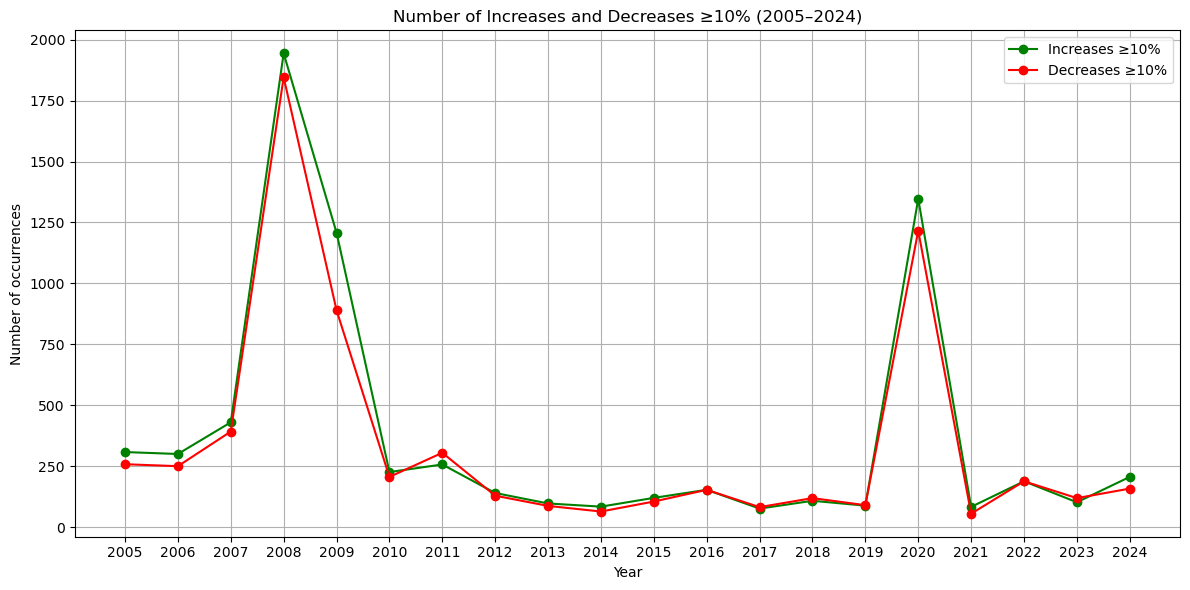

In [21]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(counts.index, counts.get('Increase', 0), label='Increases ≥10%', marker='o', color='green')
plt.plot(counts.index, counts.get('Decrease', 0), label='Decreases ≥10%', marker='o', color='red')
plt.title('Number of Increases and Decreases ≥10% (2005–2024)')
plt.xlabel('Year')
plt.ylabel('Number of occurrences')
plt.xticks(ticks=counts.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Load VIX data
vix = pd.read_csv('VIX_History.csv', parse_dates=["DATE"], date_format='%m/%d/%Y')
vix = vix.rename(columns={"DATE": "Date", "CLOSE": "VIX_Close"})
vix = vix[['Date', 'VIX_Close']]

In [25]:
# Calculate average yearly VIX for each year
vix['Year'] = vix['Date'].dt.year
vix_yearly = vix.groupby('Year')['VIX_Close'].mean().reindex(all_years)

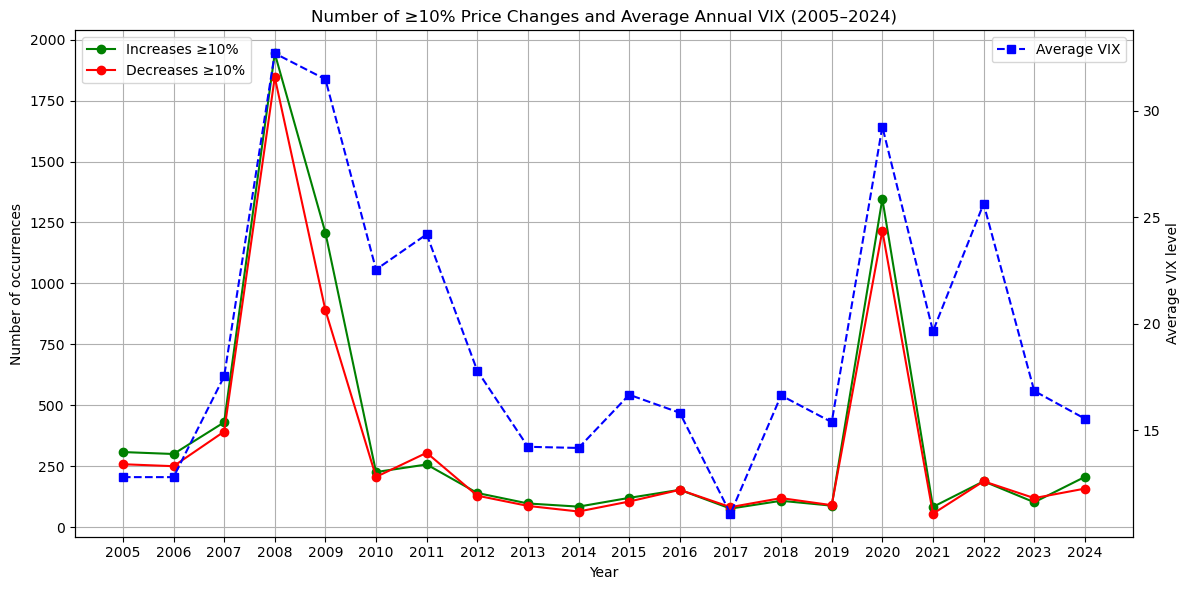

In [27]:
# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis — number of occurrences
ax1.plot(counts.index, counts.get('Increase', 0), label='Increases ≥10%', marker='o', color='green')
ax1.plot(counts.index, counts.get('Decrease', 0), label='Decreases ≥10%', marker='o', color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of occurrences')
ax1.set_xticks(all_years)
ax1.legend(loc='upper left')
ax1.grid(True)

# Right axis — VIX
ax2 = ax1.twinx()
ax2.plot(vix_yearly.index, vix_yearly.values, label='Average VIX', color='blue', linestyle='--', marker='s')
ax2.set_ylabel('Average VIX level')
ax2.legend(loc='upper right')

plt.title('Number of ≥10% Price Changes and Average Annual VIX (2005–2024)')
plt.tight_layout()
plt.show()

In [29]:
# Merge dataframes on 'Date' (left join, keeping only dates from 'results')
results_with_vix = pd.merge(results, vix, on='Date', how='left')

# Keep only rows where VIX_Close <= 20.0
results_filtered = results_with_vix[results_with_vix['VIX_Close'] <= 20.0].copy()

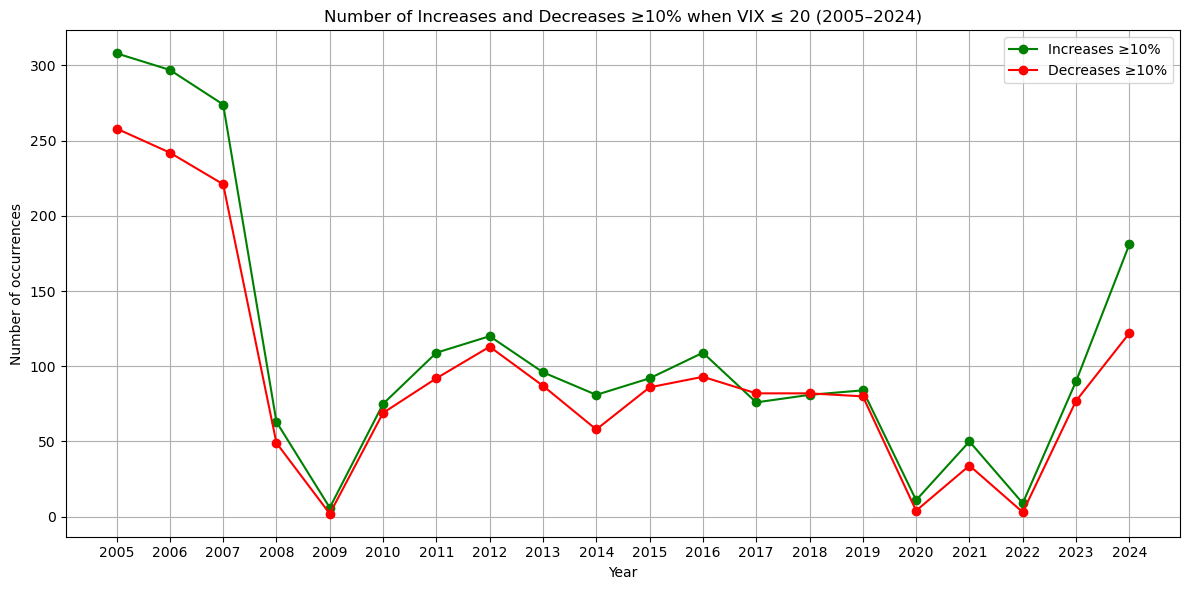

In [31]:
# Group and count occurrences
counts_filtered = results_filtered.groupby(['Year_x', 'Change_Type']).size().unstack(fill_value=0)

# Ensure all years are on the X-axis
all_years = list(range(2005, 2025))
counts_filtered = counts_filtered.reindex(all_years, fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(counts_filtered.index, counts_filtered.get('Increase', 0), label='Increases ≥10%', marker='o', color='green')
plt.plot(counts_filtered.index, counts_filtered.get('Decrease', 0), label='Decreases ≥10%', marker='o', color='red')
plt.title('Number of Increases and Decreases ≥10% when VIX ≤ 20 (2005–2024)')
plt.xlabel('Year')
plt.ylabel('Number of occurrences')
plt.xticks(ticks=all_years)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

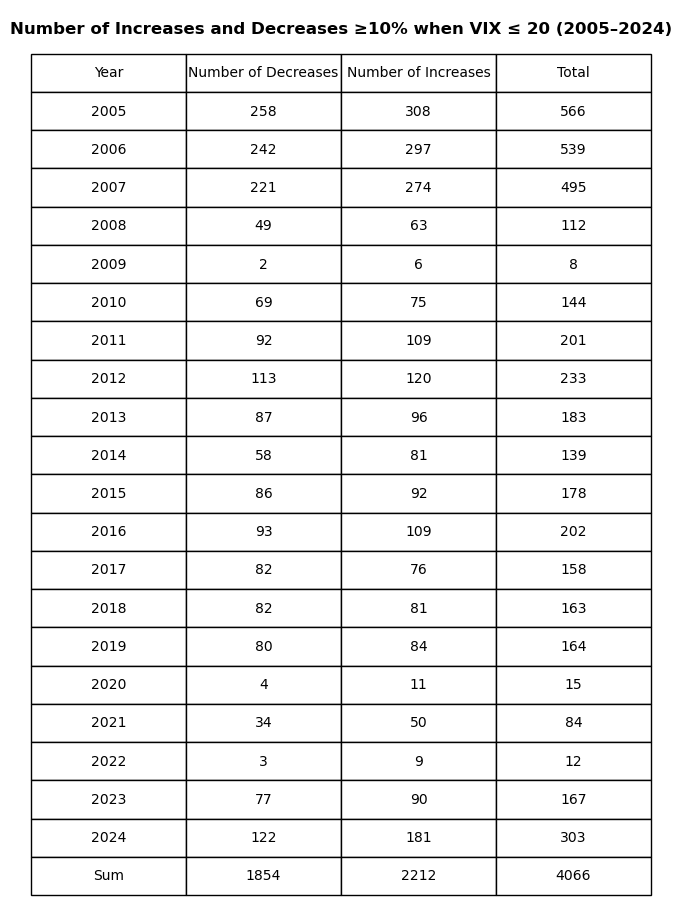

In [33]:
# Prepare table
table = results_filtered.groupby(['Year_x', 'Change_Type']).size().unstack(fill_value=0)
table = table.reindex(range(2005, 2025), fill_value=0)
table['Total'] = table.sum(axis=1)
table.loc['Sum'] = table.sum()
table.columns.name = None
table = table.rename(columns={'Increase': 'Number of Increases', 'Decrease': 'Number of Decreases'})
table_reset = table.reset_index().rename(columns={'Year_x': 'Year'})

# Drawing table
fig, ax = plt.subplots(figsize=(8, len(table_reset) * 0.5 + 1))
ax.axis('off')

# Draw table manually
tbl = ax.table(
    cellText=table_reset.values,
    colLabels=table_reset.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 0.95]
)

# Add title as text above the table
ax.text(0.5, 0.97, "Number of Increases and Decreases ≥10% when VIX ≤ 20 (2005–2024)",
        ha='center', va='bottom', fontsize=12, weight='bold')

# Table styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.show()

In [35]:
# Calculate percentage returns relative to Close
results_filtered['Return_1Y'] = (results_filtered['Close_After_1Y'] - results_filtered['Close']) / results_filtered['Close'] * 100
results_filtered['Return_3Y'] = (results_filtered['Close_After_3Y'] - results_filtered['Close']) / results_filtered['Close'] * 100
results_filtered['Return_5Y'] = (results_filtered['Close_After_5Y'] - results_filtered['Close']) / results_filtered['Close'] * 100

# Split into increases and decreases
increases = results_filtered[results_filtered['Change_Type'] == 'Increase']
decreases = results_filtered[results_filtered['Change_Type'] == 'Decrease']

# Tables with percentage returns
table_increases = increases[['Return_1Y', 'Return_3Y', 'Return_5Y']]
table_decreases = decreases[['Return_1Y', 'Return_3Y', 'Return_5Y']]

In [37]:
table_increases.describe()

,Return_1Y,Return_3Y,Return_5Y
count,1717.000000,1075.000000,714.000000
mean,155.481506,101.170457,79.316170
std,2526.257096,1994.423334,238.401976
min,-99.915903,-98.167608,-99.851485
25%,-42.857141,-59.927516,-50.975148
50%,-1.174583,-5.555550,26.908345
75%,28.295824,46.744822,120.777140
max,56670.663231,63850.197800,1904.362537


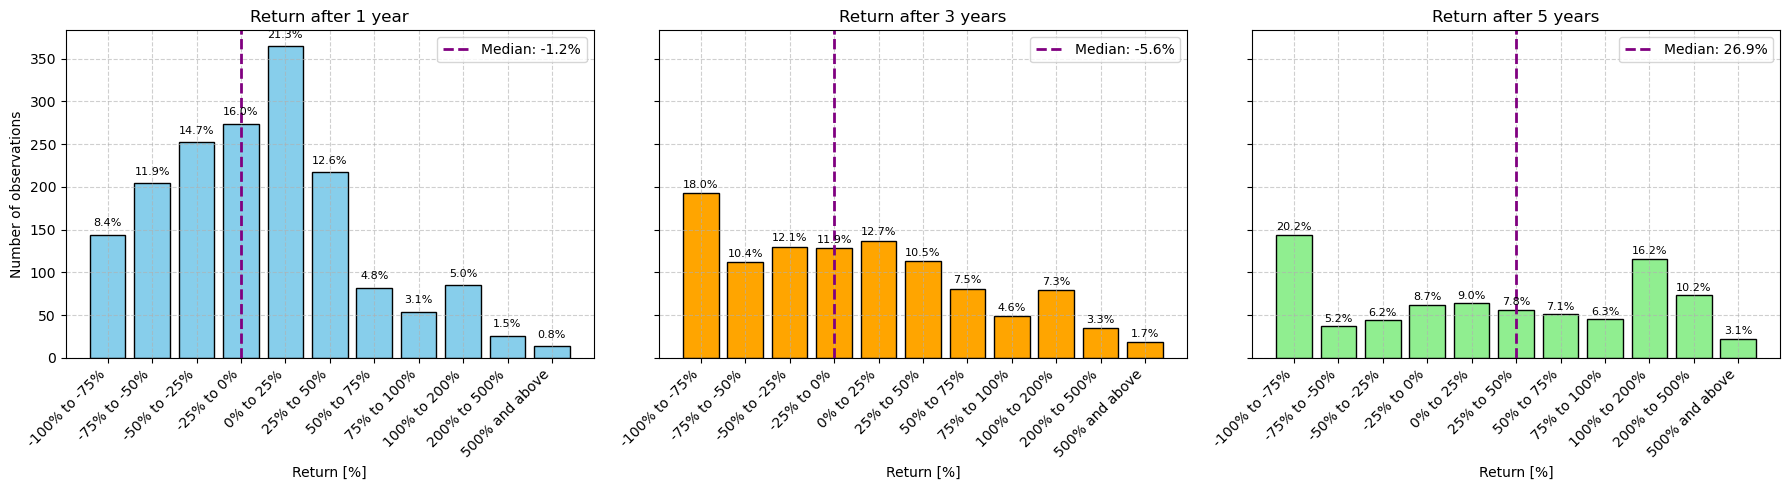

In [39]:
# Bins for returns — last bin from 500 to infinity
bins = [-100, -75, -50, -25, 0, 25, 50, 75, 100, 200, 500, np.inf]
labels = [f'{bins[i]}% to {bins[i+1]}%' if bins[i+1] != np.inf else f'{bins[i]}% and above' for i in range(len(bins)-1)]

def prepare_hist_data(data):
    # Assign data to bins
    categories = pd.cut(data.dropna(), bins=bins, labels=labels, right=False)
    counts = categories.value_counts().sort_index()
    return counts

def find_median_bin(median, bins):
    # Find the index of the bin containing the median
    for i in range(len(bins)-1):
        if bins[i] <= median < bins[i+1]:
            return i
    return len(bins) - 2  # if median >= last bin

# No filtering — take all values
filtered_1Y = table_increases['Return_1Y']
filtered_3Y = table_increases['Return_3Y']
filtered_5Y = table_increases['Return_5Y']

# Prepare data
counts_1Y = prepare_hist_data(filtered_1Y)
counts_3Y = prepare_hist_data(filtered_3Y)
counts_5Y = prepare_hist_data(filtered_5Y)

# Medians
median_1Y = table_increases['Return_1Y'].median()
median_3Y = table_increases['Return_3Y'].median()
median_5Y = table_increases['Return_5Y'].median()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

hist_data = [
    (counts_1Y, 'Return after 1 year', 'skyblue', median_1Y),
    (counts_3Y, 'Return after 3 years', 'orange', median_3Y),
    (counts_5Y, 'Return after 5 years', 'lightgreen', median_5Y)
]

for ax, (counts, title, color, median) in zip(axes, hist_data):
    ax.bar(range(len(counts)), counts.values, color=color, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Return [%]')
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Draw median line
    median_bin_index = find_median_bin(median, bins)
    ax.axvline(median_bin_index, color='purple', linestyle='--', linewidth=2, label=f'Median: {median:.1f}%')
    
    # Percentage labels above bars
    total = counts.sum()
    for i, val in enumerate(counts.values):
        pct = val / total * 100
        ax.text(i, val + max(counts.values)*0.02, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax.legend()

axes[0].set_ylabel('Number of observations')

plt.tight_layout()
plt.show()

In [41]:
table_decreases.describe()

,Return_1Y,Return_3Y,Return_5Y
count,1.478000e+03,911.000000,591.000000
mean,8.077158e+03,822.234161,67.830093
std,2.052359e+05,2317.360769,218.226387
min,-9.914353e+01,-97.500000,-99.777778
25%,-2.464700e+01,-48.751363,-53.050674
50%,1.478169e+01,14.278754,23.914093
75%,5.812869e+01,87.369060,115.146816
max,7.866567e+06,19366.667219,2182.335601


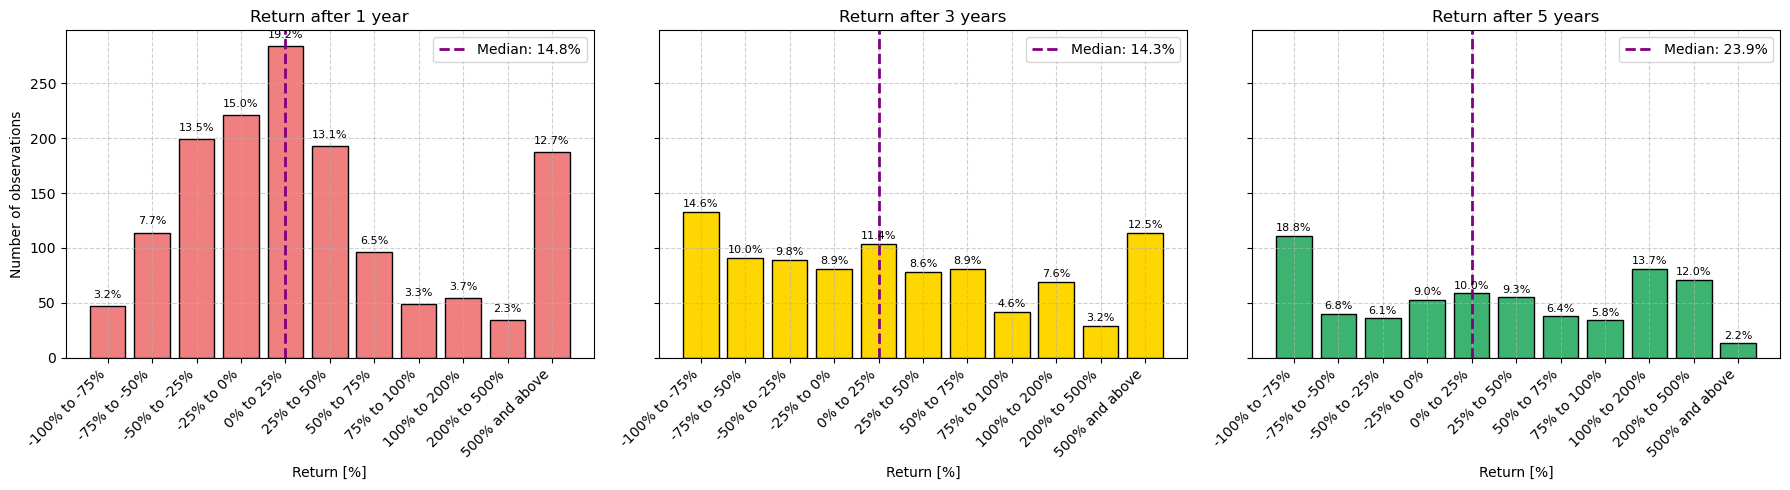

In [43]:
# Repeat the same for decreases
filtered_1Y = table_decreases['Return_1Y']
filtered_3Y = table_decreases['Return_3Y']
filtered_5Y = table_decreases['Return_5Y']

counts_1Y = prepare_hist_data(filtered_1Y)
counts_3Y = prepare_hist_data(filtered_3Y)
counts_5Y = prepare_hist_data(filtered_5Y)

median_1Y = filtered_1Y.median()
median_3Y = filtered_3Y.median()
median_5Y = filtered_5Y.median()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

hist_data = [
    (counts_1Y, 'Return after 1 year', 'lightcoral', median_1Y),
    (counts_3Y, 'Return after 3 years', 'gold', median_3Y),
    (counts_5Y, 'Return after 5 years', 'mediumseagreen', median_5Y)
]

for ax, (counts, title, color, median) in zip(axes, hist_data):
    ax.bar(range(len(counts)), counts.values, color=color, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Return [%]')
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    median_bin_index = find_median_bin(median, bins)
    ax.axvline(median_bin_index, color='purple', linestyle='--', linewidth=2, label=f'Median: {median:.1f}%')
    
    total = counts.sum()
    for i, val in enumerate(counts.values):
        pct = val / total * 100
        ax.text(i, val + max(counts.values)*0.02, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax.legend()

axes[0].set_ylabel('Number of observations')

plt.tight_layout()
plt.show()